In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from time import time

%matplotlib inline

Используем один из "игрушечных" датасетов из той же библиотеки.

In [0]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)

In [0]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [0]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [0]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [0]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
    #    print(i)
        
    return trees, train_errors, test_errors

Обучим модели.

In [0]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [0]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, only_print=True):
    train_prediction = gb_predict(X_train, trees, coefs, eta)    
    train_mse = mean_squared_error(y_train, train_prediction)
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)
    
    if only_print:
        print('Ошибка алгоритма из {} деревьев глубиной {} \
        с шагом {} на тренировочной выборке: {}'.format(n_trees, max_depth, eta, train_mse))

        print('Ошибка алгоритма из {} деревьев глубиной {} \
        с шагом {} на тестовой выборке: {}'.format(n_trees, max_depth, eta, test_mse))
    
    else:
        return train_mse, test_mse

In [0]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3         с шагом 1 на тренировочной выборке: 1079.27278807
Ошибка алгоритма из 10 деревьев глубиной 3         с шагом 1 на тестовой выборке: 5636.86678622


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [0]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

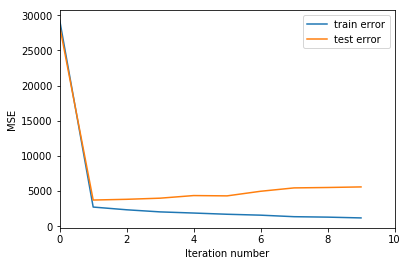

In [0]:
get_error_plot(n_trees, train_errors, test_errors)

**1). Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.**

Глубина:

In [0]:
n_trees = 20
eta = 0.1
tree_depths = np.arange(1, 25)
train_mse_list = []
test_mse_list = []

for max_depth in tree_depths:
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_mse, test_mse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, only_print=False)
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

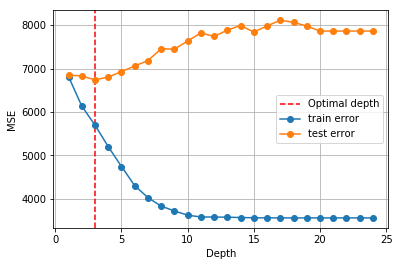

In [0]:
plt.axvline(np.argmin(test_mse_list)+1, c='red', ls='--', label='Optimal depth')
plt.plot(tree_depths, train_mse_list, marker='o', label='train error')
plt.plot(tree_depths, test_mse_list, marker='o', label='test error')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.legend(loc='center right')
plt.grid(True)
plt.show()

Количество деревьев:

In [0]:
eta = 0.1
max_depth = 3
total_trees_counts = np.arange(1, 45, 3)
train_mse_list = []
test_mse_list = []
time_costs = []

for n_trees in total_trees_counts:
    time_start = time()
    trees = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[0]
    train_mse, test_mse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, only_print=False)
    time_finish = time()
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    time_costs.append(time_finish - time_start)

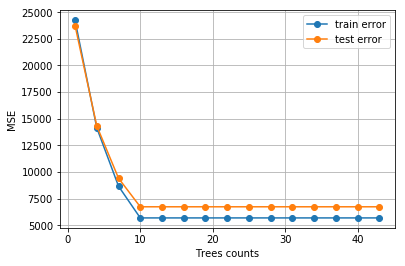

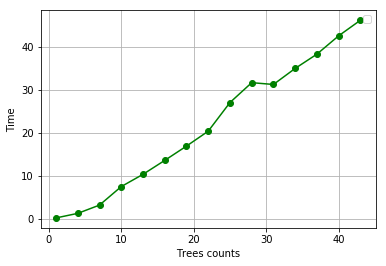

In [0]:
plt.plot(total_trees_counts, train_mse_list, marker='o', label='train error')
plt.plot(total_trees_counts, test_mse_list, marker='o', label='test error')
plt.xlabel('Trees counts')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

plt.plot(total_trees_counts, time_costs, marker='o', c='g')
plt.xlabel('Trees counts')
plt.ylabel('Time')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

**Вывод:**
 - маленькая глубина деревьев в модели градиентного бустинга может способствовать ее недообучению, а слишком большая - переобучению, что видно по выскоим уровням ошибки на соответствующих участках графика;
 - на некотором количестве деревьев модель градиентного бустинга сходится, и дальнейшее добавление в нее деревьев может стать нецелесообразным (ошибка не изменится). Кроме того, это лишний раз увеличит время обучения.

**2). Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.**

In [0]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errors = []
    test_errors = []
    
    np.random.seed(42)
    n_samples = X_train.shape[0]
    n_samples_for_sgb = int(0.5 * n_samples)
    indexes = np.arange(n_samples)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        sgb_indexes = np.random.choice(indexes, n_samples_for_sgb)

        if len(trees) == 0:
            tree.fit(X_train[sgb_indexes], y_train[sgb_indexes])            
        else:
            target = gb_predict(X_train[sgb_indexes], trees, coefs, eta)
            tree.fit(X_train[sgb_indexes], bias(y_train[sgb_indexes], target))
            
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [0]:
n_trees = 10
max_depth = 3
eta = 1

%time train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[1:]
%time sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)[1:]

Wall time: 5.6 s
Wall time: 4.41 s


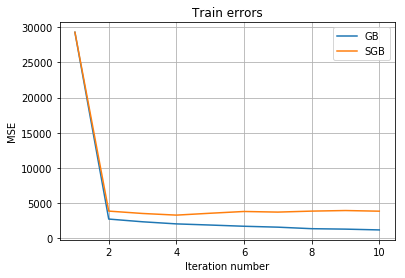

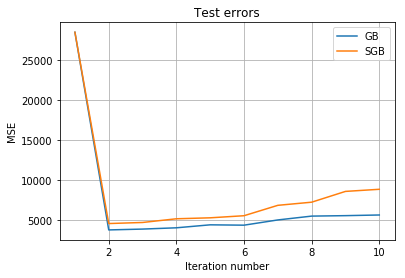

In [0]:
iterations = np.arange(1, n_trees+1)

for title, gb_errors, sgb_errors in zip(['Train errors', 'Test errors'],
                                        [train_errors, test_errors],
                                        [sgb_train_errors, sgb_test_errors]):
    plt.plot(iterations, gb_errors, label='GB')
    plt.plot(iterations, sgb_errors, label='SGB')
    plt.title(title)
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()    

**Вывод:** модель стохастического градиентного бустинга показывает несколько худшее качество, чем полный вариант (но не критично). Тем не менее, обучается она быстрее.